In [2]:
import os
import uuid
import numpy as np 
import pandas as pd
#import tensorflow as tf
import matplotlib.pyplot as plt
import seaborn as sns
# This is used in order to show the plotted figures within this notebook
%matplotlib inline 
# This is used in order to show the tensorboard within this notebook             
#%load_ext tensorboard  
from sklearn.preprocessing import OneHotEncoder, LabelEncoder
from sklearn.neighbors import KNeighborsClassifier

from sklearn.metrics import accuracy_score, roc_auc_score
from sklearn.preprocessing import LabelEncoder, StandardScaler
from collections import Counter
from math import ceil
import numpy as np
import seaborn as sns
%matplotlib inline
import matplotlib.pyplot as plt
from sklearn.tree import DecisionTreeClassifier, plot_tree
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier, AdaBoostClassifier
from sklearn.neural_network import MLPClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import GaussianNB
from sklearn.model_selection import train_test_split, RandomizedSearchCV, GridSearchCV, TimeSeriesSplit
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix, plot_roc_curve
from sklearn.model_selection import learning_curve
from sklearn.multioutput import MultiOutputClassifier
from imblearn.combine import SMOTETomek
from imblearn.under_sampling import TomekLinks
from evaluate import run
import datetime
import numpy as np
import pandas as pd
import seaborn as sns

In [3]:
data = pd.read_csv('output/loan_dev.csv')
data_comp = pd.read_csv('output/loan_comp.csv')
data

,Id,loan_date,loan_duration,loan_payments,Predicted,account_frequency,account_district_region,account_district_no_inhabitants,account_district_no_municipalities_0_499,account_district_no_municipalities_500_1999,...,mean_trans_balance,mean_trans_amount_absolute,mean_trans_amount_credit,mean_trans_amount_withdrawal,mean_trans_amount_signed,owner_male,owner_age,account_age_months,has_disponent,owner_profile
0,5314,930705,12,1.772411,1.0,1,7,-0.555052,-0.696637,-0.532164,...,-2.341062,-1.095832,-1.277012,-3.548971,2.064417,0,0.738673,-1.637968,0,2
1,5316,930711,36,0.209593,0.0,2,3,-0.276803,0.251722,-0.103896,...,0.662960,0.445111,0.304714,0.259442,0.870102,1,-0.939421,-1.451810,0,2
2,6863,930728,60,-0.928164,0.0,2,3,-0.907746,1.315032,-0.165077,...,-0.997871,-0.973106,-1.279854,-0.405514,0.362060,1,1.697584,-1.265651,0,2
3,5325,930803,36,-0.553325,0.0,2,2,-0.344741,1.286294,0.446734,...,-0.150482,-0.193451,-0.489775,-0.135044,0.842490,0,1.377947,-1.079493,0,2
4,7240,930906,60,0.195440,0.0,1,4,1.729778,-1.127709,-1.327519,...,1.047898,1.926310,1.743982,1.716445,0.944229,1,-1.738513,-1.079493,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
323,6818,961212,48,-0.414986,0.0,2,1,0.598928,-0.208089,1.731539,...,0.068220,-1.137214,-1.012047,-1.070137,-0.537260,0,-0.859512,1.899044,1,2
324,5625,961215,60,-0.204510,1.0,2,7,-2.110760,0.366674,-0.715708,...,0.900256,0.595847,0.285059,0.536220,0.540540,1,1.697584,0.037459,0,2
325,6805,961221,48,-1.466909,0.0,2,1,0.822776,-1.127709,-1.205157,...,-0.097886,-0.313022,-0.621863,-0.182382,0.514984,0,0.259218,-0.893334,0,2
326,7233,961225,36,-0.426400,0.0,2,6,-0.570905,0.998913,-0.042715,...,1.007047,0.910852,0.869015,0.695252,-0.583636,1,0.578855,1.340569,0,2


# Outlier Detection

- Standard Deviation
- Z-Score

--------------------------------------------------
Statistics of Id
--------------------------------------------------
Min: 4959
Max: 7308
Mean: 6205.658536585366
Median: 6227.5
Standard deviation: 667.985674726219
Skewness: -0.126359735421936
Variance: 446204.86163944204
Kurtosis: -1.168537695082133
Interquartile Range: 1133.0 | Q1: 5604.25 | Q3: 6737.25


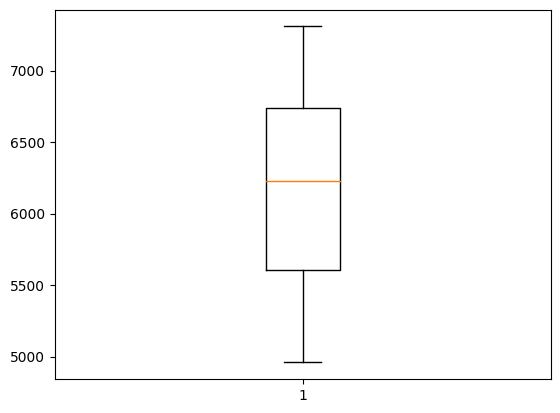

<Figure size 1000x700 with 0 Axes>

--------------------------------------------------
Statistics of loan_date
--------------------------------------------------
Min: 930705
Max: 961227
Mean: 949989.125
Median: 950565.5
Standard deviation: 9495.504646353156
Skewness: -0.2574182118951275
Variance: 90164608.48891437
Kurtosis: -1.1466194893417647
Interquartile Range: 19716.0 | Q1: 940809.25 | Q3: 960525.25


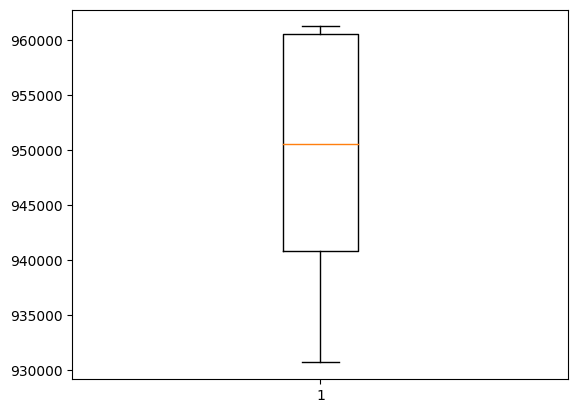

<Figure size 1000x700 with 0 Axes>

--------------------------------------------------
Statistics of loan_duration
--------------------------------------------------
Min: 12
Max: 60
Mean: 35.853658536585364
Median: 36.0
Standard deviation: 16.73475166172723
Skewness: 0.05589223008522359
Variance: 280.0519131796823
Kurtosis: -1.267191280387405
Interquartile Range: 24.0 | Q1: 24.0 | Q3: 48.0


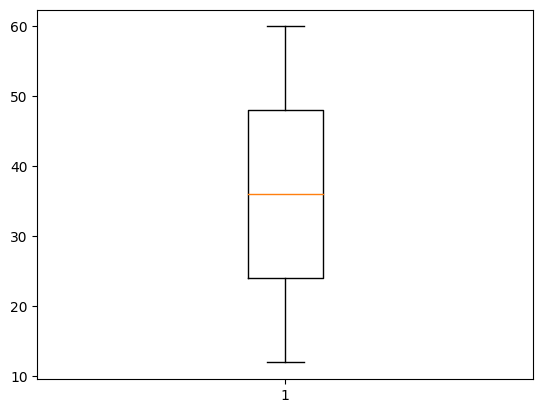

<Figure size 1000x700 with 0 Axes>

--------------------------------------------------
Statistics of loan_payments
--------------------------------------------------
Min: -1.7495217719223348
Max: 2.528480822574191
Mean: -1.4622449592624014e-16
Median: -0.12438300616882525
Standard deviation: 1.0015278847718296
Skewness: 0.2693393857351612
Variance: 1.003058103975535
Kurtosis: -0.8465605235895719
Interquartile Range: 1.6157792083162439 | Q1: -0.8136801691401305 | Q3: 0.8020990391761134


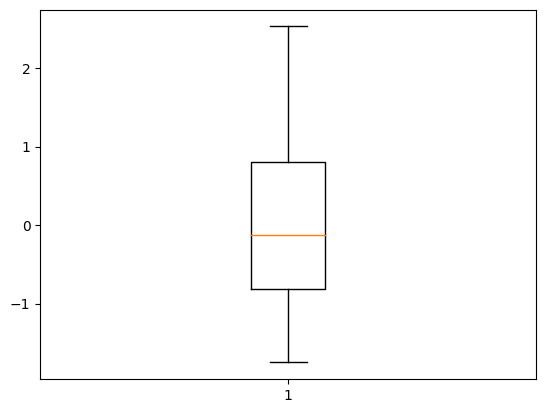

<Figure size 1000x700 with 0 Axes>

--------------------------------------------------
Statistics of Predicted
--------------------------------------------------
Min: 0.0
Max: 1.0
Mean: 0.1402439024390244
Median: 0.0
Standard deviation: 0.3477704456064715
Skewness: 2.0816213381952395
Variance: 0.12094428283732378
Kurtosis: 2.3474239284321956
Interquartile Range: 0.0 | Q1: 0.0 | Q3: 0.0


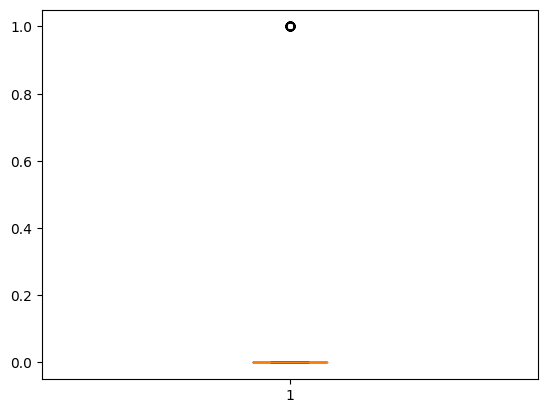

<Figure size 1000x700 with 0 Axes>

--------------------------------------------------
Statistics of account_frequency
--------------------------------------------------
Min: 0
Max: 2
Mean: 1.7347560975609757
Median: 2.0
Standard deviation: 0.5527904760035754
Skewness: -1.992102848776567
Variance: 0.30557731036025954
Kurtosis: 2.948430966811482
Interquartile Range: 0.0 | Q1: 2.0 | Q3: 2.0


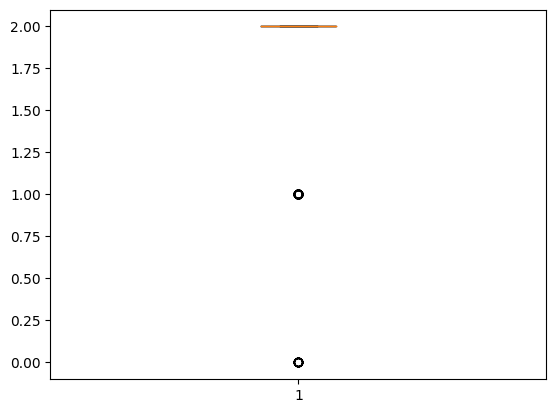

<Figure size 1000x700 with 0 Axes>

--------------------------------------------------
Statistics of account_district_region
--------------------------------------------------
Min: 0
Max: 7
Mean: 2.951219512195122
Median: 3.0
Standard deviation: 2.3115317294764783
Skewness: 0.2869188721277375
Variance: 5.343178936376519
Kurtosis: -1.1604025800414484
Interquartile Range: 4.0 | Q1: 1.0 | Q3: 5.0


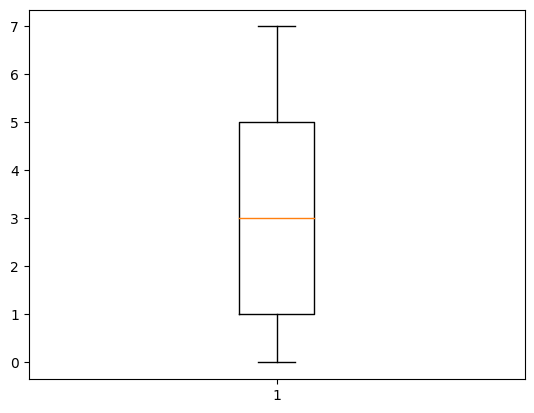

<Figure size 1000x700 with 0 Axes>

--------------------------------------------------
Statistics of account_district_no_inhabitants
--------------------------------------------------
Min: -2.2878599521138283
Max: 1.7297780049882752
Mean: -4.34263717668675e-09
Median: -0.1206245719730472
Standard deviation: 1.0015278847718296
Skewness: 0.10222420672802587
Variance: 1.003058103975535
Kurtosis: -0.40869992585674453
Interquartile Range: 1.206911929003199 | Q1: -0.6049226338409734 | Q3: 0.6019892951622258


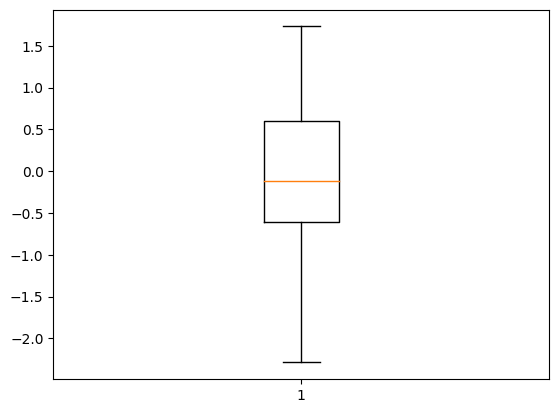

<Figure size 1000x700 with 0 Axes>

--------------------------------------------------
Statistics of account_district_no_municipalities_0_499
--------------------------------------------------
Min: -1.1277088962137816
Max: 3.2117492819911884
Mean: -2.166288828536891e-17
Median: -0.1506123527769008
Standard deviation: 1.0015278847718296
Skewness: 0.8336320112638349
Variance: 1.003058103975535
Kurtosis: 0.5133208170929926
Interquartile Range: 1.6668117505687967 | Q1: -0.9840182280612992 | Q3: 0.6827935225074975


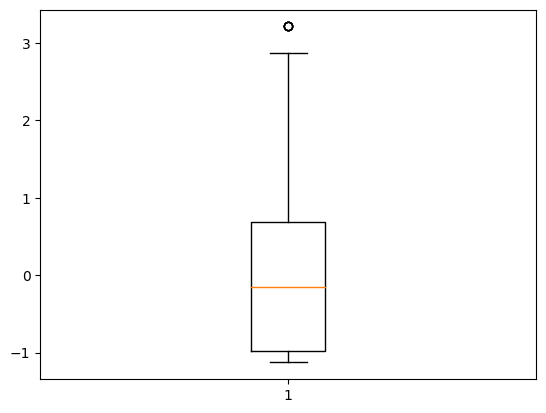

<Figure size 1000x700 with 0 Axes>

--------------------------------------------------
Statistics of account_district_no_municipalities_500_1999
--------------------------------------------------
Min: -1.327519097830525
Max: 2.9551615943415763
Mean: -9.206727521281785e-17
Median: 0.0796474153117371
Standard deviation: 1.0015278847718296
Skewness: 0.29245967470850165
Variance: 1.003058103975535
Kurtosis: -0.4387791204903646
Interquartile Range: 1.7130722768688402 | Q1: -0.8992510286133144 | Q3: 0.8138212482555259


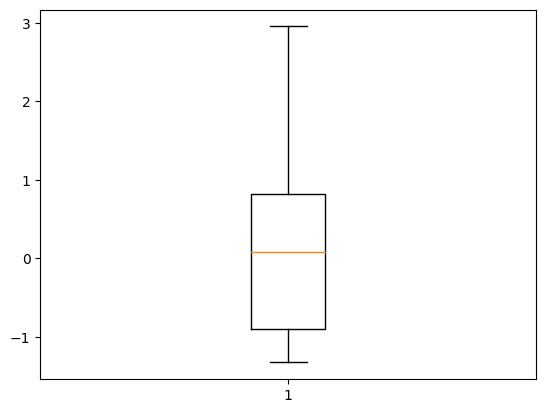

<Figure size 1000x700 with 0 Axes>

--------------------------------------------------
Statistics of account_district_no_municipalities_2000_9999
--------------------------------------------------
Min: -1.2251048720751436
Max: 3.284821031860289
Mean: 3.791005449939559e-17
Median: -0.0976233960912852
Standard deviation: 1.0015278847718299
Skewness: 0.8556854929742536
Variance: 1.0030581039755355
Kurtosis: 0.7722079693016441
Interquartile Range: 1.35297777118063 | Q1: -0.7741122816816002 | Q3: 0.5788654894990297


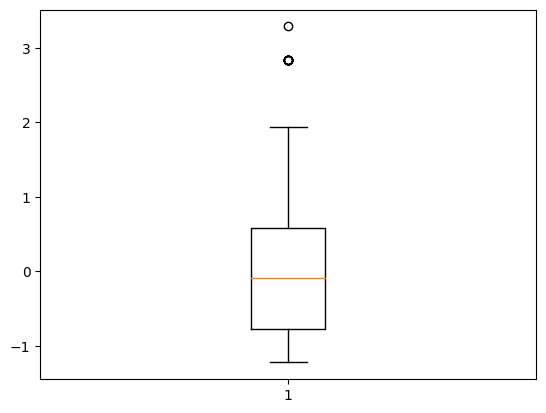

<Figure size 1000x700 with 0 Axes>

--------------------------------------------------
Statistics of account_district_no_municipalities_10000_plus
--------------------------------------------------
Min: 0
Max: 5
Mean: 1.649390243902439
Median: 1.0
Standard deviation: 1.0704251606786939
Skewness: 1.217285588191101
Variance: 1.1458100246140075
Kurtosis: 1.3523008239536378
Interquartile Range: 1.0 | Q1: 1.0 | Q3: 2.0


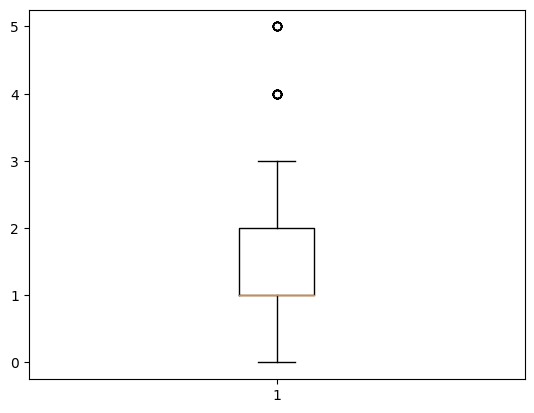

<Figure size 1000x700 with 0 Axes>

--------------------------------------------------
Statistics of account_district_no_cities
--------------------------------------------------
Min: -1.4641314273610573
Max: 2.0057754236102343
Mean: -7.040438692744895e-17
Median: -0.0761686869725406
Standard deviation: 1.0015278847718296
Skewness: -0.011958016794837953
Variance: 1.003058103975535
Kurtosis: -0.9696877864885018
Interquartile Range: 1.0409720552913875 | Q1: -0.4231593720696698 | Q3: 0.6178126832217177


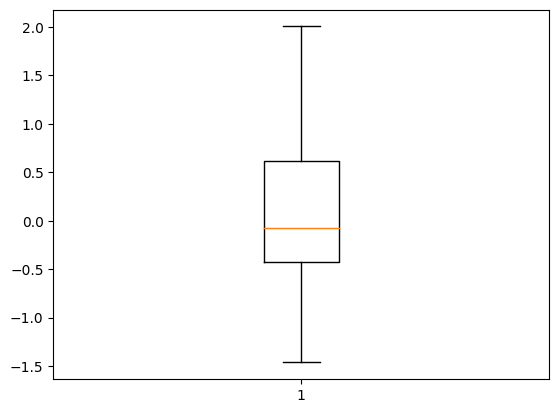

<Figure size 1000x700 with 0 Axes>

--------------------------------------------------
Statistics of account_district_ratio_urban_inhabitants
--------------------------------------------------
Min: -1.6916207813530115
Max: 1.5261661456292452
Mean: -1.408087738548979e-16
Median: -0.3236962329687237
Standard deviation: 1.0015278847718296
Skewness: 0.34076282492223237
Variance: 1.003058103975535
Kurtosis: -1.1662927154161014
Interquartile Range: 1.7159907590941685 | Q1: -0.7618215331629794 | Q3: 0.9541692259311891


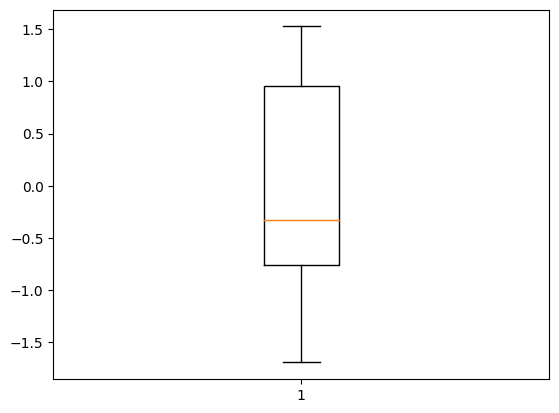

<Figure size 1000x700 with 0 Axes>

--------------------------------------------------
Statistics of account_district_average_salary
--------------------------------------------------
Min: -1.2040562327776758
Max: 2.099853903320019
Mean: 4.874149864208005e-15
Median: -0.398462159369655
Standard deviation: 1.0015278847718296
Skewness: 1.0770921471734831
Variance: 1.003058103975535
Kurtosis: 0.04327901610050011
Interquartile Range: 1.1481994798467654 | Q1: -0.8016157506553312 | Q3: 0.3465837291914343


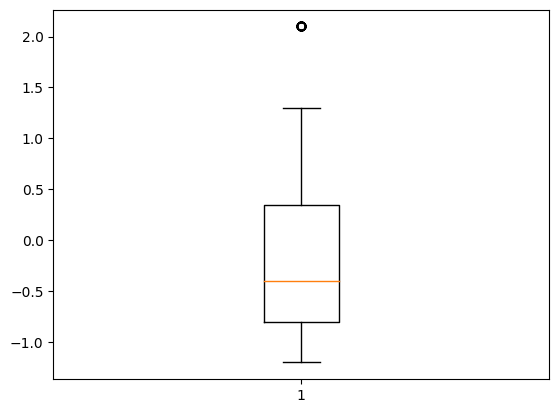

<Figure size 1000x700 with 0 Axes>

--------------------------------------------------
Statistics of account_district_unemployment_rate_95
--------------------------------------------------
Min: -1.3279361370900062
Max: 2.324299562815868
Mean: 8.12358310701334e-17
Median: -0.0431780469103491
Standard deviation: 1.0015278847718296
Skewness: 0.5215025631294232
Variance: 1.003058103975535
Kurtosis: -0.5054389350630801
Interquartile Range: 1.258855709329266 | Q1: -0.7425423298710547 | Q3: 0.5163133794582112


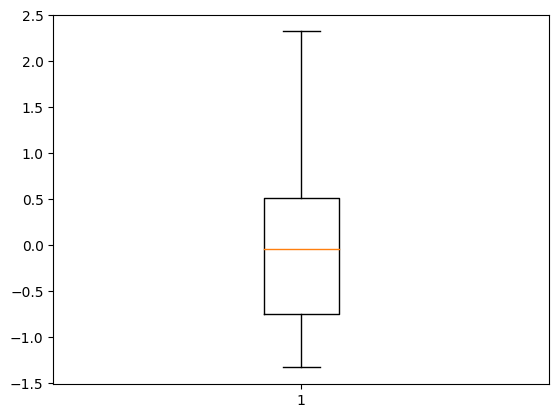

<Figure size 1000x700 with 0 Axes>

--------------------------------------------------
Statistics of account_district_unemployment_rate_96
--------------------------------------------------
Min: -1.3784542912505005
Max: 2.682945974672684
Mean: -2.0579743871100464e-16
Median: 0.0070401138470406
Standard deviation: 1.0015278847718296
Skewness: 0.47530237148558674
Variance: 1.003058103975535
Kurtosis: -0.32251540276695767
Interquartile Range: 1.3266335316783644 | Q1: -0.730984683639558 | Q3: 0.5956488480388064


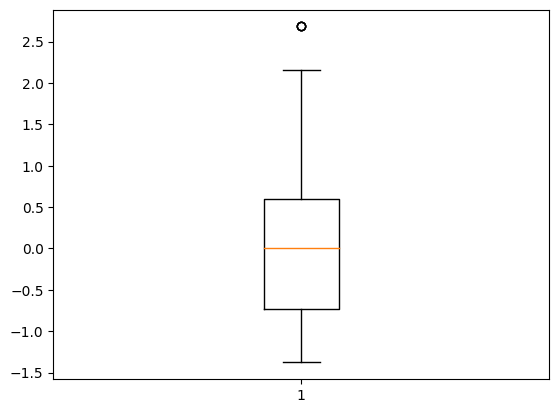

<Figure size 1000x700 with 0 Axes>

--------------------------------------------------
Statistics of account_district_no_enterpreneurs_per_1000_inhabitants
--------------------------------------------------
Min: -1.7461401312183678
Max: 1.8499116189026608
Mean: 1.7330310628295127e-16
Median: -0.3035379756465598
Standard deviation: 1.0015278847718296
Skewness: 0.5916848426357392
Variance: 1.003058103975535
Kurtosis: -0.6495980694707728
Interquartile Range: 1.3798803227208603 | Q1: -0.6589616951352664 | Q3: 0.7209186275855939


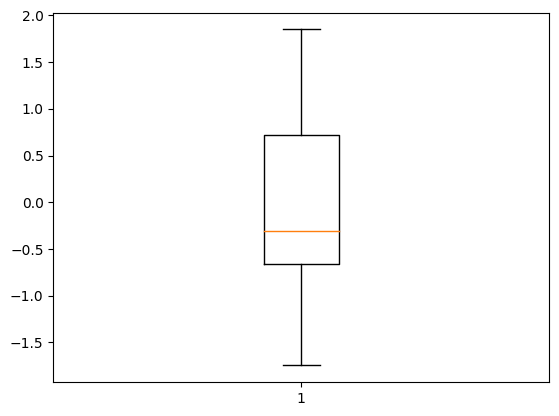

<Figure size 1000x700 with 0 Axes>

--------------------------------------------------
Statistics of account_district_no_crimes_95
--------------------------------------------------
Min: -1.288162045909741
Max: 1.98248123283734
Mean: 1.624716621402668e-16
Median: -0.3018031572151901
Standard deviation: 1.0015278847718296
Skewness: 0.8940653066788892
Variance: 1.003058103975535
Kurtosis: -0.42120490477917993
Interquartile Range: 1.325058455491622 | Q1: -0.8005491354142982 | Q3: 0.5245093200773239


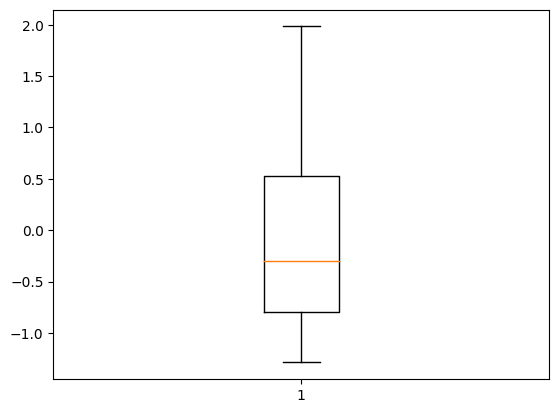

<Figure size 1000x700 with 0 Axes>

--------------------------------------------------
Statistics of account_district_no_crimes_96
--------------------------------------------------
Min: -1.0994291268201748
Max: 2.151829530568983
Mean: -4.332577657073782e-17
Median: -0.2809574424272856
Standard deviation: 1.0015278847718296
Skewness: 1.1952369174403192
Variance: 1.003058103975535
Kurtosis: 0.272805277408521
Interquartile Range: 1.217558601239056 | Q1: -0.8110468384409626 | Q3: 0.4065117627980935


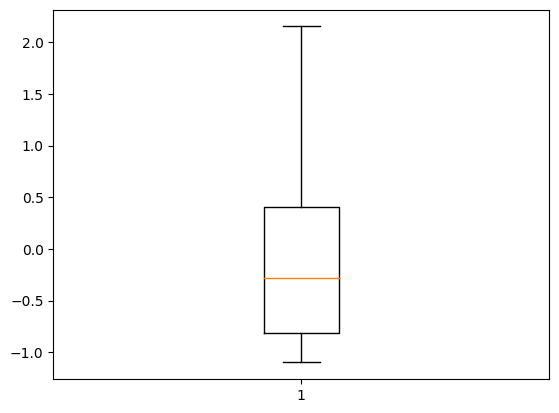

<Figure size 1000x700 with 0 Axes>

--------------------------------------------------
Statistics of owner_card_type
--------------------------------------------------
Min: 0
Max: 3
Mean: 0.0701219512195122
Median: 0.0
Standard deviation: 0.3886272992765306
Skewness: 5.687591792502146
Variance: 0.1510311777429701
Kurtosis: 32.352447970416584
Interquartile Range: 0.0 | Q1: 0.0 | Q3: 0.0


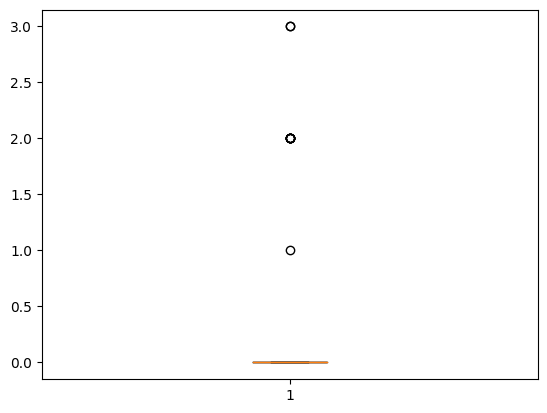

<Figure size 1000x700 with 0 Axes>

--------------------------------------------------
Statistics of owner_district_region
--------------------------------------------------
Min: 0
Max: 7
Mean: 2.9115853658536586
Median: 3.0
Standard deviation: 2.3268384764402272
Skewness: 0.2996346679662918
Variance: 5.414177295442678
Kurtosis: -1.176324234067887
Interquartile Range: 4.0 | Q1: 1.0 | Q3: 5.0


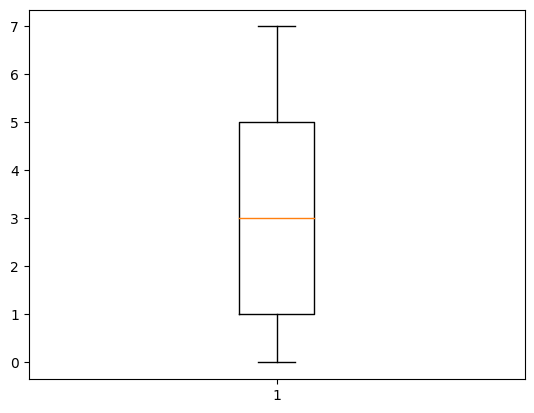

<Figure size 1000x700 with 0 Axes>

--------------------------------------------------
Statistics of owner_district_no_inhabitants
--------------------------------------------------
Min: -2.2578547651771337
Max: 1.7937416548851923
Mean: 2.6807824253144024e-14
Median: -0.1074678032376033
Standard deviation: 1.0015278847718296
Skewness: 0.11485386481540125
Variance: 1.003058103975535
Kurtosis: -0.35569779803591794
Interquartile Range: 1.2961005353056712 | Q1: -0.6446260469629915 | Q3: 0.6514744883426796


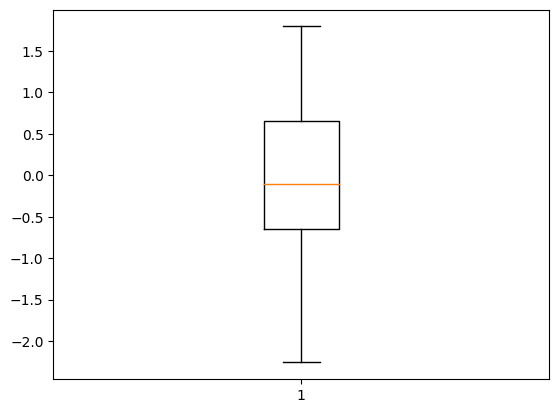

<Figure size 1000x700 with 0 Axes>

--------------------------------------------------
Statistics of owner_district_no_municipalities_0_499
--------------------------------------------------
Min: -1.1631458869244553
Max: 3.1800604978459326
Mean: 3.791005449939559e-17
Median: -0.1852053764463547
Standard deviation: 1.0015278847718296
Skewness: 0.7991391184788172
Variance: 1.003058103975535
Kurtosis: 0.4547152728576447
Interquartile Range: 1.5963440685745467 | Q1: -0.9330422374001964 | Q3: 0.6633018311743502


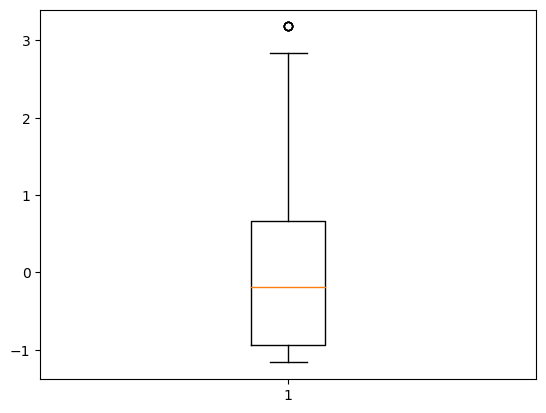

<Figure size 1000x700 with 0 Axes>

--------------------------------------------------
Statistics of owner_district_no_municipalities_500_1999
--------------------------------------------------
Min: -1.346904839175736
Max: 2.9304029211942364
Mean: 4.332577657073782e-17
Median: -0.0026081144880304
Standard deviation: 1.0015278847718296
Skewness: 0.34593730457102784
Variance: 1.003058103975535
Kurtosis: -0.28245853723059655
Interquartile Range: 1.542886013562026 | Q1: -0.7358608734085973 | Q3: 0.8070251401534286


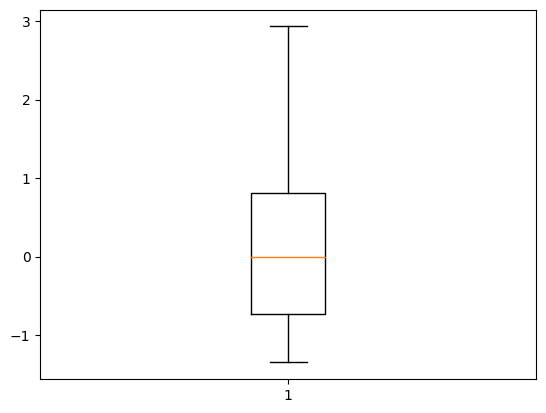

<Figure size 1000x700 with 0 Axes>

--------------------------------------------------
Statistics of owner_district_no_municipalities_2000_9999
--------------------------------------------------
Min: -1.2506443394302509
Max: 3.2033333297676023
Mean: -6.498866485610672e-17
Median: -0.1371499221307876
Standard deviation: 1.0015278847718299
Skewness: 0.9276375616077919
Variance: 1.0030581039755355
Kurtosis: 1.0322046318703682
Interquartile Range: 1.1134944172994632 | Q1: -0.582547689050573 | Q3: 0.5309467282488903


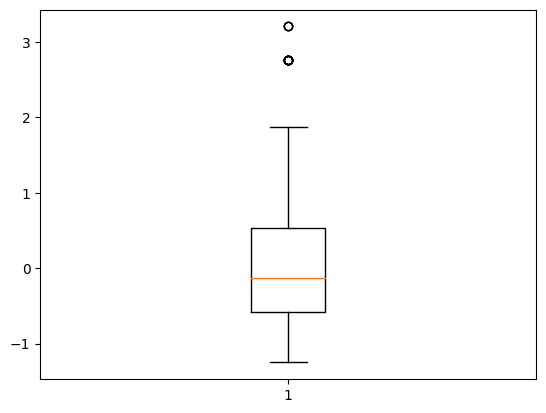

<Figure size 1000x700 with 0 Axes>

--------------------------------------------------
Statistics of owner_district_no_municipalities_10000_plus
--------------------------------------------------
Min: 0
Max: 5
Mean: 1.673780487804878
Median: 1.0
Standard deviation: 1.092222311884515
Skewness: 1.1716388401327196
Variance: 1.1929495785783546
Kurtosis: 1.1561680259186056
Interquartile Range: 1.0 | Q1: 1.0 | Q3: 2.0


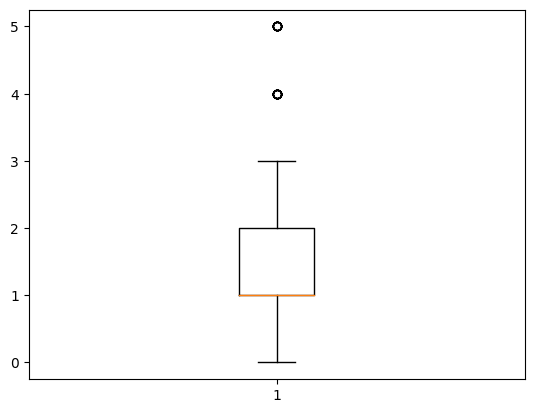

<Figure size 1000x700 with 0 Axes>

--------------------------------------------------
Statistics of owner_district_no_cities
--------------------------------------------------
Min: -1.5035169584508248
Max: 1.991547268139328
Mean: 2.7078610356711135e-17
Median: -0.1054912678147637
Standard deviation: 1.0015278847718296
Skewness: -0.004885489702675284
Variance: 1.003058103975535
Kurtosis: -0.9115689698877913
Interquartile Range: 1.0485192679770456 | Q1: -0.4549976904737789 | Q3: 0.5935215775032668


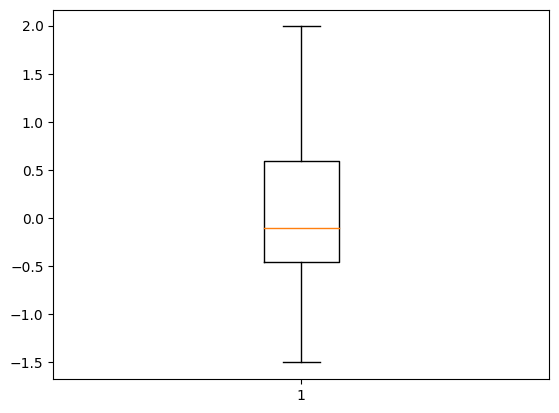

<Figure size 1000x700 with 0 Axes>

--------------------------------------------------
Statistics of owner_district_ratio_urban_inhabitants
--------------------------------------------------
Min: -1.6815634150064382
Max: 1.5853087590532748
Mean: 1.9496599456832017e-16
Median: -0.297714385147558
Standard deviation: 1.0015278847718299
Skewness: 0.3836903577660631
Variance: 1.0030581039755355
Kurtosis: -1.0825587351672674
Interquartile Range: 1.6223158716113473 | Q1: -0.7524076378154756 | Q3: 0.8699082337958717


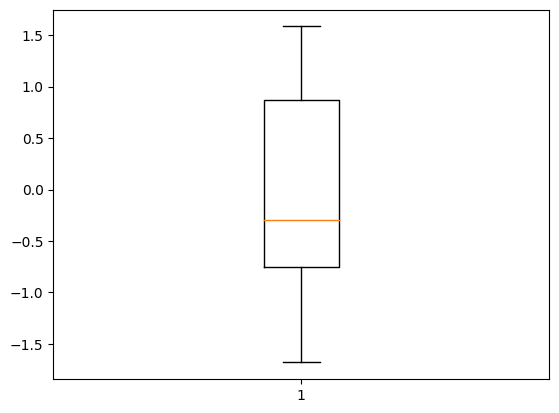

<Figure size 1000x700 with 0 Axes>

--------------------------------------------------
Statistics of owner_district_average_salary
--------------------------------------------------
Min: -1.0725892731925193
Max: 2.29056758929303
Mean: -6.498866485610672e-16
Median: -0.401627714529187
Standard deviation: 1.0015278847718296
Skewness: 1.3374941120938693
Variance: 1.003058103975535
Kurtosis: 0.6971647454885632
Interquartile Range: 1.0252277436249955 | Q1: -0.7414727800173171 | Q3: 0.2837549636076785


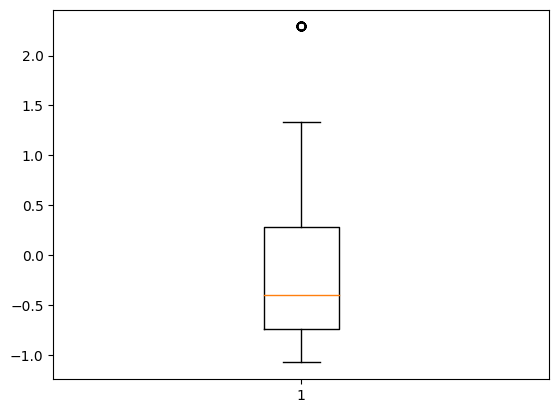

<Figure size 1000x700 with 0 Axes>

--------------------------------------------------
Statistics of owner_district_unemployment_rate_95
--------------------------------------------------
Min: -1.368067523105559
Max: 2.350972107096865
Mean: 3.5202193463724476e-17
Median: -0.0598096106371867
Standard deviation: 1.0015278847718296
Skewness: 0.5460146521601154
Variance: 1.003058103975535
Kurtosis: -0.37969268269309175
Interquartile Range: 1.226491792939099 | Q1: -0.724489033907408 | Q3: 0.502002759031691


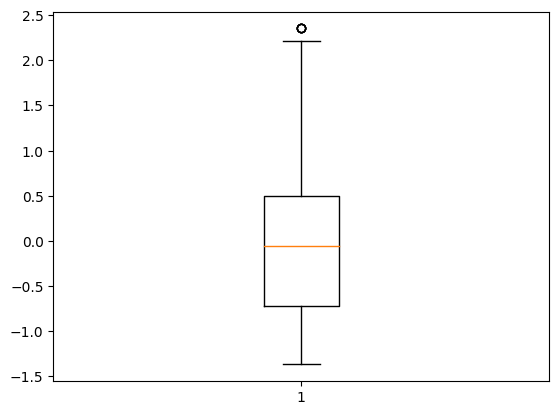

<Figure size 1000x700 with 0 Axes>

--------------------------------------------------
Statistics of owner_district_unemployment_rate_96
--------------------------------------------------
Min: -1.4078353558619816
Max: 2.675522824112868
Mean: -1.1373016349818677e-16
Median: -0.0148502911213972
Standard deviation: 1.0015278847718296
Skewness: 0.5199169308730937
Variance: 1.003058103975535
Kurtosis: -0.20275542288297554
Interquartile Range: 1.2882835729463573 | Q1: -0.7113428234916893 | Q3: 0.5769407494546679


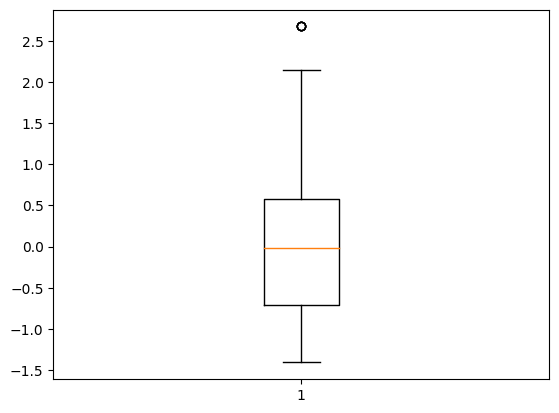

<Figure size 1000x700 with 0 Axes>

--------------------------------------------------
Statistics of owner_district_no_enterpreneurs_per_1000_inhabitants
--------------------------------------------------
Min: -1.7398836869327132
Max: 1.9599760221511908
Mean: 1.8819634197914238e-16
Median: -0.2771484531088443
Standard deviation: 1.0015278847718296
Skewness: 0.6788818744308167
Variance: 1.003058103975535
Kurtosis: -0.410865597399221
Interquartile Range: 1.2046054866784808 | Q1: -0.6213214493026961 | Q3: 0.5832840373757847


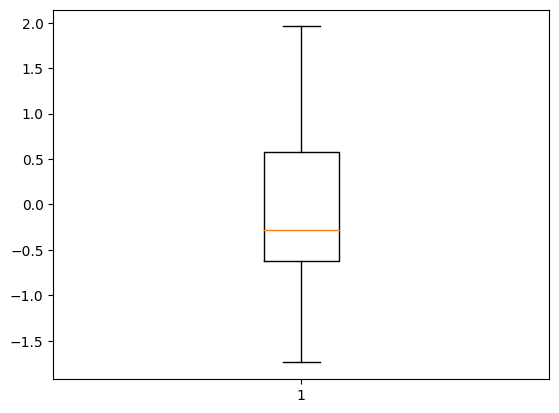

<Figure size 1000x700 with 0 Axes>

--------------------------------------------------
Statistics of owner_district_no_crimes_95
--------------------------------------------------
Min: -1.258344629066115
Max: 2.0990368493415663
Mean: 7.040438692744895e-17
Median: -0.3207550361238351
Standard deviation: 1.0015278847718296
Skewness: 1.0052306928294086
Variance: 1.003058103975535
Kurtosis: -0.14680944072396063
Interquartile Range: 1.2043938233834641 | Q1: -0.7578001138730661 | Q3: 0.4465937095103979


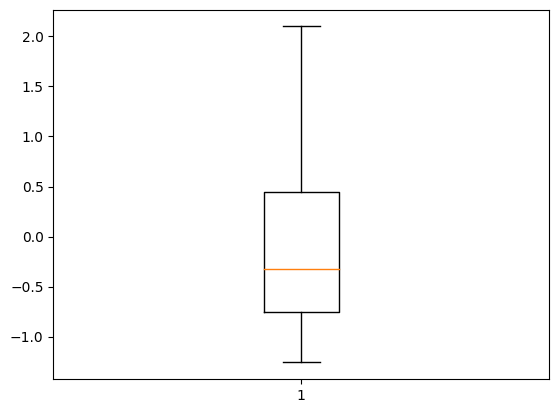

<Figure size 1000x700 with 0 Axes>

--------------------------------------------------
Statistics of owner_district_no_crimes_96
--------------------------------------------------
Min: -1.0681945174771117
Max: 2.2851732027053906
Mean: -9.748299728416009e-17
Median: -0.2687135337949984
Standard deviation: 1.0015278847718296
Skewness: 1.3203077555788083
Variance: 1.003058103975535
Kurtosis: 0.6737856391737096
Interquartile Range: 1.071279754582817 | Q1: -0.7707552919865815 | Q3: 0.3005244625962355


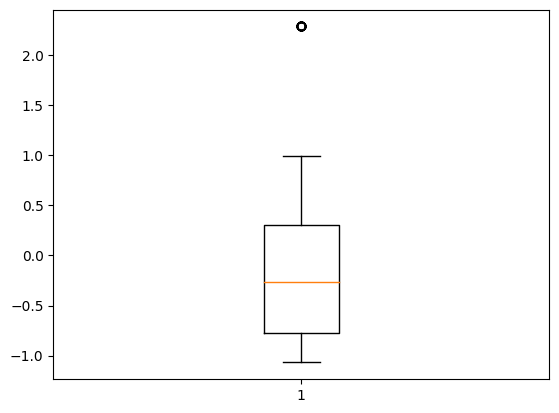

<Figure size 1000x700 with 0 Axes>

--------------------------------------------------
Statistics of count_trans_credits
--------------------------------------------------
Min: -2.672533200237576
Max: 2.4989678023444086
Mean: -2.951568528881514e-16
Median: 0.0157141748539086
Standard deviation: 1.0015278847718296
Skewness: -0.03026060640137436
Variance: 1.003058103975535
Kurtosis: -0.5593077972731444
Interquartile Range: 1.4276469448829365 | Q1: -0.6967666606205787 | Q3: 0.7308802842623577


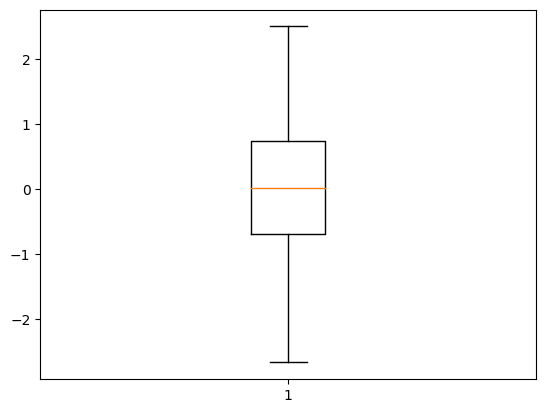

<Figure size 1000x700 with 0 Axes>

--------------------------------------------------
Statistics of count_trans_withdrawals
--------------------------------------------------
Min: -2.247923634751168
Max: 2.2573947775659877
Mean: -1.597638011045957e-16
Median: 0.0697260624610644
Standard deviation: 1.0015278847718294
Skewness: -0.11614686693173235
Variance: 1.0030581039755349
Kurtosis: -0.6389688990225739
Interquartile Range: 1.3768218098905605 | Q1: -0.6811309380087948 | Q3: 0.6956908718817656


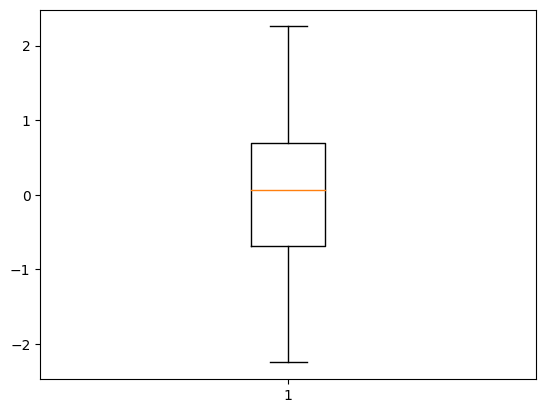

<Figure size 1000x700 with 0 Axes>

--------------------------------------------------
Statistics of count_trans_credit_cash
--------------------------------------------------
Min: -1.1412617163976535
Max: 3.24896286616412
Mean: -1.3539305178355567e-17
Median: -0.1557010958225616
Standard deviation: 1.0015278847718296
Skewness: 0.818497189915036
Variance: 1.003058103975535
Kurtosis: 0.17760961845172574
Interquartile Range: 1.6127355609410592 | Q1: -0.9620688762930912 | Q3: 0.6506666846479681


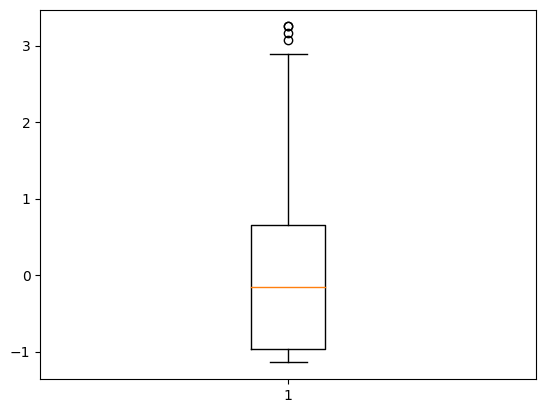

<Figure size 1000x700 with 0 Axes>

--------------------------------------------------
Statistics of count_trans_withdrawal_cash
--------------------------------------------------
Min: -2.202826364869002
Max: 2.25413469358204
Mean: 3.791005449939559e-17
Median: 0.035402925287636
Standard deviation: 1.0015278847718296
Skewness: -0.15186225345771298
Variance: 1.003058103975535
Kurtosis: -0.7916772999880215
Interquartile Range: 1.5303781808341967 | Q1: -0.7595232988605065 | Q3: 0.7708548819736902


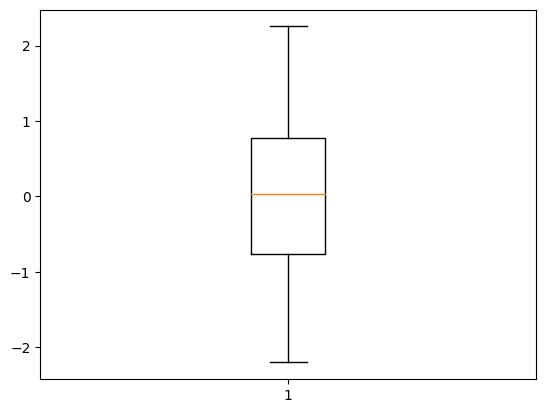

<Figure size 1000x700 with 0 Axes>

--------------------------------------------------
Statistics of count_trans_withdrawal_card
--------------------------------------------------
Min: 0
Max: 8
Mean: 0.0701219512195122
Median: 0.0
Standard deviation: 0.5888546783181915
Skewness: 10.473461059169317
Variance: 0.34674983217722083
Kurtosis: 121.64663817445185
Interquartile Range: 0.0 | Q1: 0.0 | Q3: 0.0


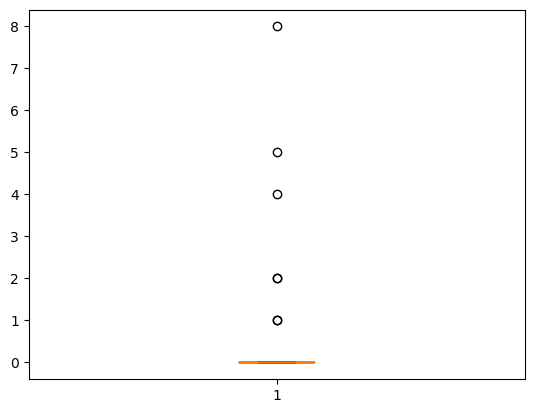

<Figure size 1000x700 with 0 Axes>

--------------------------------------------------
Statistics of count_trans_collection_other_bank
--------------------------------------------------
Min: 0
Max: 1
Mean: 0.29573170731707316
Median: 0.0
Standard deviation: 0.4570682548292009
Skewness: 0.8993032013104397
Variance: 0.20891138957261132
Kurtosis: -1.1985997179090588
Interquartile Range: 1.0 | Q1: 0.0 | Q3: 1.0


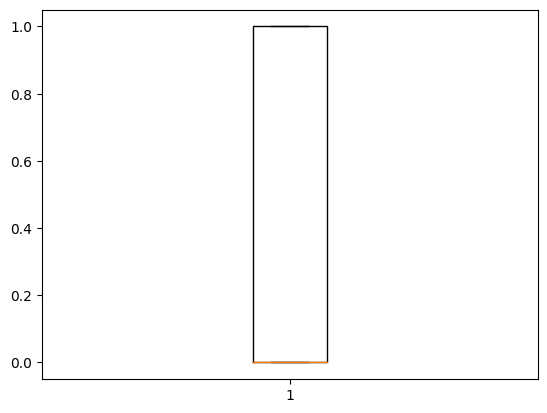

<Figure size 1000x700 with 0 Axes>

--------------------------------------------------
Statistics of count_trans_remittance_other_bank
--------------------------------------------------
Min: 0
Max: 1
Mean: 0.5670731707317073
Median: 1.0
Standard deviation: 0.4962378038122684
Skewness: -0.2719851734722619
Variance: 0.24625195793242338
Kurtosis: -1.9378779091146312
Interquartile Range: 1.0 | Q1: 0.0 | Q3: 1.0


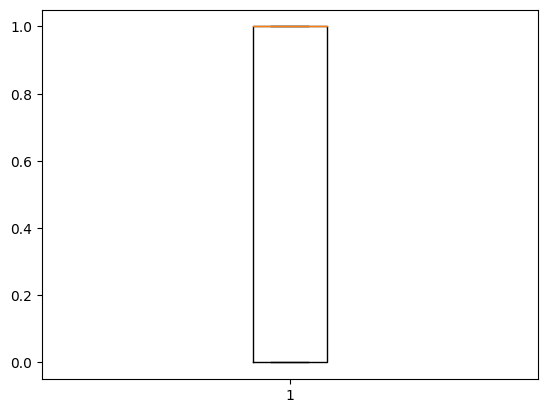

<Figure size 1000x700 with 0 Axes>

--------------------------------------------------
Statistics of count_trans_ksymbol_interest_credited
--------------------------------------------------
Min: -3.5213202531915546
Max: 3.39256846083638
Mean: 1.8007275887212906e-16
Median: 0.0319060858497449
Standard deviation: 1.0015278847718296
Skewness: 0.030046100519060977
Variance: 1.0030581039755353
Kurtosis: 0.6435062791838417
Interquartile Range: 1.2860474442781964 | Q1: -0.6232940788088502 | Q3: 0.6627533654693462


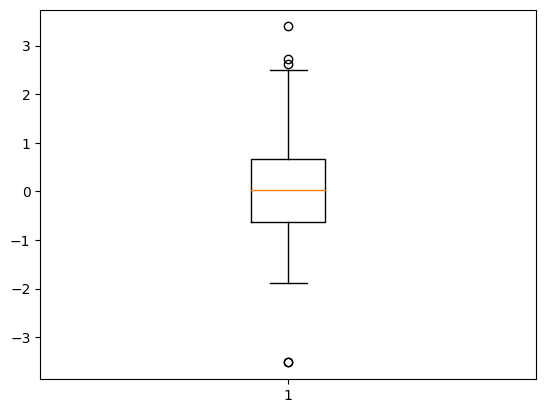

<Figure size 1000x700 with 0 Axes>

--------------------------------------------------
Statistics of count_trans_ksymbol_household
--------------------------------------------------
Min: 0
Max: 1
Mean: 0.6067073170731707
Median: 1.0
Standard deviation: 0.4892272003111421
Skewness: -0.438904309171294
Variance: 0.23934325352427832
Kurtosis: -1.818488855484993
Interquartile Range: 1.0 | Q1: 0.0 | Q3: 1.0


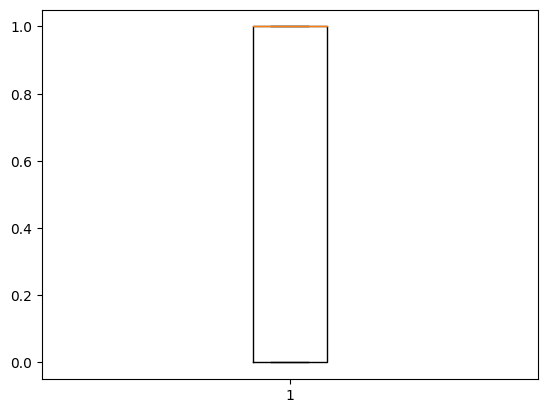

<Figure size 1000x700 with 0 Axes>

--------------------------------------------------
Statistics of count_trans_ksymbol_payment_for_statement
--------------------------------------------------
Min: -1.4210969134051137
Max: 2.6353252887829006
Mean: 2.7078610356711135e-17
Median: -0.1304171217998363
Standard deviation: 1.0015278847718296
Skewness: 0.3241873351115071
Variance: 1.003058103975535
Kurtosis: -0.7784529339255828
Interquartile Range: 1.659445446349642 | Q1: -0.8679484312885661 | Q3: 0.791497015061076


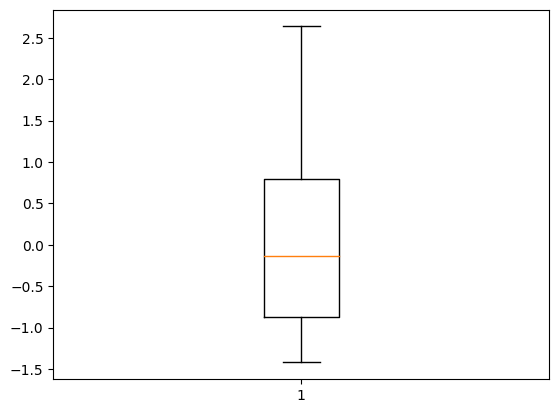

<Figure size 1000x700 with 0 Axes>

--------------------------------------------------
Statistics of count_trans_ksymbol_insurance_payment
--------------------------------------------------
Min: 0
Max: 0
Mean: 0.0
Median: 0.0
Standard deviation: 0.0
Skewness: 0
Variance: 0.0
Kurtosis: 0
Interquartile Range: 0.0 | Q1: 0.0 | Q3: 0.0


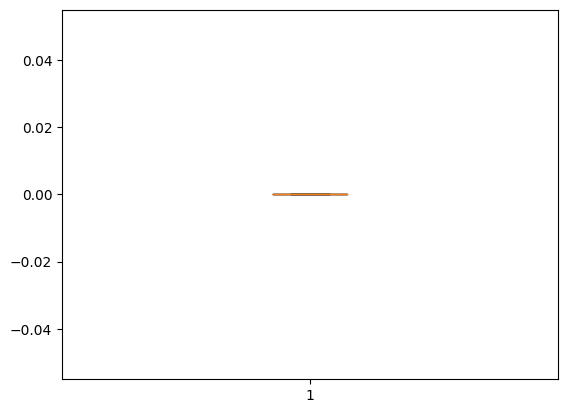

<Figure size 1000x700 with 0 Axes>

--------------------------------------------------
Statistics of count_trans_ksymbol_sanction_interest_if_negative_balance
--------------------------------------------------
Min: 0
Max: 1
Mean: 0.042682926829268296
Median: 0.0
Standard deviation: 0.20245012240637317
Skewness: 4.545541330549654
Variance: 0.040986052062355484
Kurtosis: 18.776401078504154
Interquartile Range: 0.0 | Q1: 0.0 | Q3: 0.0


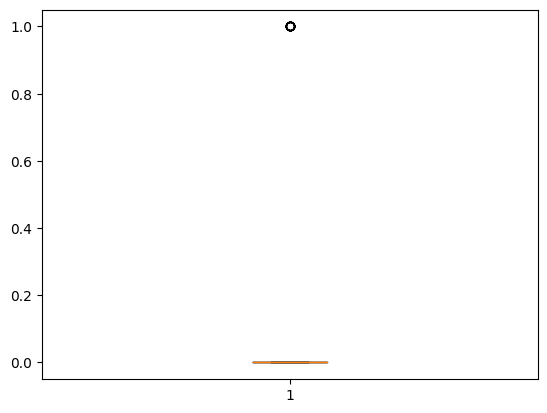

<Figure size 1000x700 with 0 Axes>

--------------------------------------------------
Statistics of count_trans_ksymbol_oldage_pension
--------------------------------------------------
Min: 0
Max: 0
Mean: 0.0
Median: 0.0
Standard deviation: 0.0
Skewness: 0
Variance: 0.0
Kurtosis: 0
Interquartile Range: 0.0 | Q1: 0.0 | Q3: 0.0


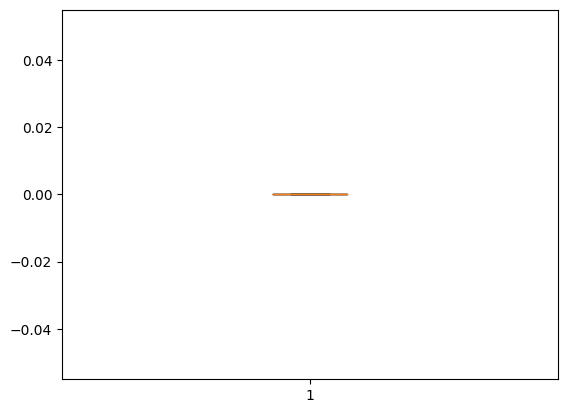

<Figure size 1000x700 with 0 Axes>

--------------------------------------------------
Statistics of last_trans_balance
--------------------------------------------------
Min: -3.4258456466942317
Max: 2.691696087741237
Mean: -9.31504196270863e-16
Median: 0.018277691368628498
Standard deviation: 1.0015278847718296
Skewness: 0.008626612298968968
Variance: 1.003058103975535
Kurtosis: 0.1783706644386811
Interquartile Range: 1.3591870082914546 | Q1: -0.7335902973963707 | Q3: 0.625596710895084


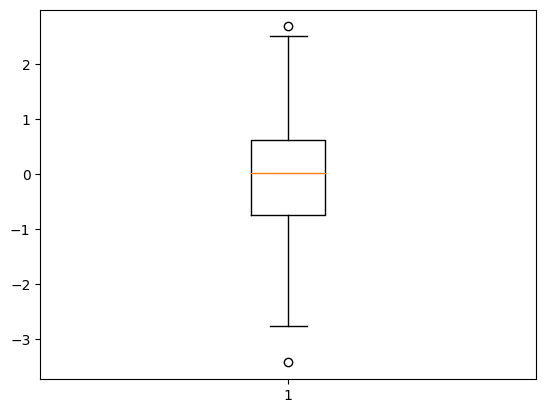

<Figure size 1000x700 with 0 Axes>

--------------------------------------------------
Statistics of mean_trans_balance
--------------------------------------------------
Min: -2.34106231723474
Max: 2.4841151533478936
Mean: 4.8741498642080043e-17
Median: -0.08365628092814781
Standard deviation: 1.0015278847718296
Skewness: 0.2339246346962322
Variance: 1.003058103975535
Kurtosis: -0.7022090368578726
Interquartile Range: 1.5399810410361057 | Q1: -0.8069826179502906 | Q3: 0.7329984230858151


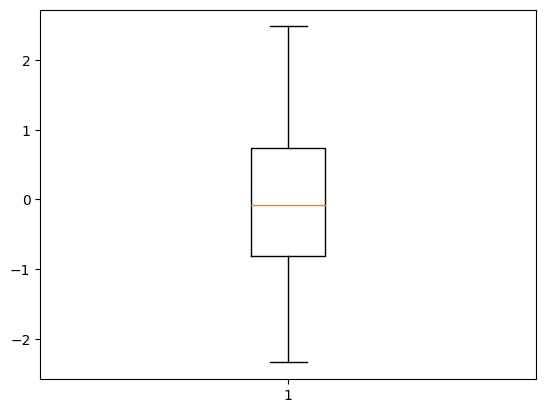

<Figure size 1000x700 with 0 Axes>

--------------------------------------------------
Statistics of mean_trans_amount_absolute
--------------------------------------------------
Min: -2.5019402128299046
Max: 2.847465332447264
Mean: -5.95729427847645e-17
Median: 0.00241697826205925
Standard deviation: 1.0015278847718296
Skewness: -0.05597822070516782
Variance: 1.003058103975535
Kurtosis: -0.6026032332740914
Interquartile Range: 1.510725074830936 | Q1: -0.7175930861900329 | Q3: 0.7931319886409032


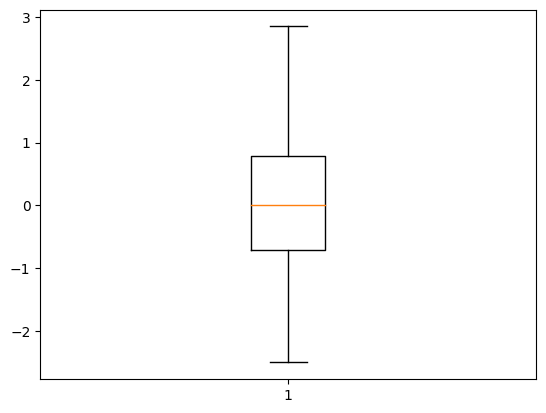

<Figure size 1000x700 with 0 Axes>

--------------------------------------------------
Statistics of mean_trans_amount_credit
--------------------------------------------------
Min: -1.7302093013055424
Max: 2.79583331634268
Mean: 1.624716621402668e-17
Median: -0.07096880584129209
Standard deviation: 1.0015278847718296
Skewness: 0.3906793930781971
Variance: 1.003058103975535
Kurtosis: -0.5976578184596693
Interquartile Range: 1.52647674694677 | Q1: -0.7752687549308734 | Q3: 0.7512079920158965


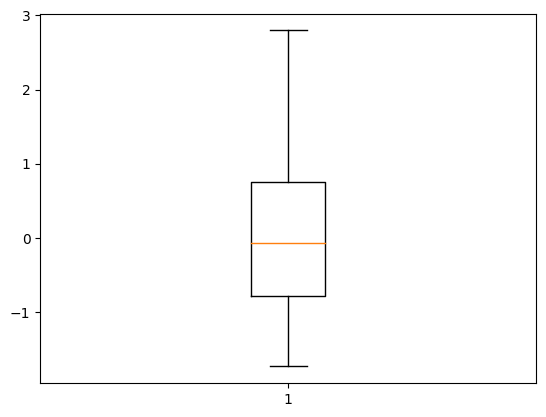

<Figure size 1000x700 with 0 Axes>

--------------------------------------------------
Statistics of mean_trans_amount_withdrawal
--------------------------------------------------
Min: -3.548971418863623
Max: 3.4737040021112184
Mean: 4.657520981354315e-16
Median: -0.009829221826685448
Standard deviation: 1.0015278847718296
Skewness: 0.06892600672032827
Variance: 1.003058103975535
Kurtosis: 0.8052296806772854
Interquartile Range: 1.357389961962854 | Q1: -0.6737666211342002 | Q3: 0.6836233408286538


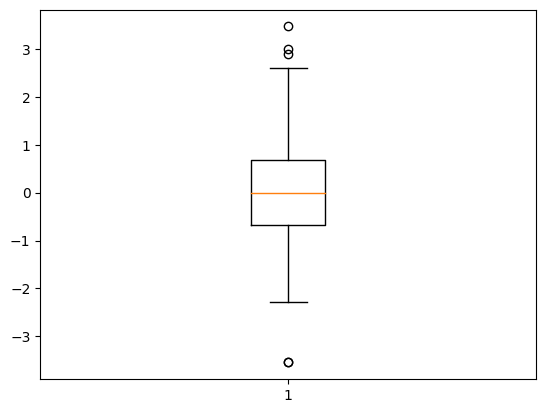

<Figure size 1000x700 with 0 Axes>

--------------------------------------------------
Statistics of mean_trans_amount_signed
--------------------------------------------------
Min: -3.5622844602901247
Max: 2.163723442612882
Mean: -8.990098638428097e-16
Median: -0.11634137252063326
Standard deviation: 1.0015278847718296
Skewness: 0.003925365354279242
Variance: 1.003058103975535
Kurtosis: -0.14826919942944317
Interquartile Range: 1.339335542635748 | Q1: -0.6449029117657585 | Q3: 0.6944326308699894


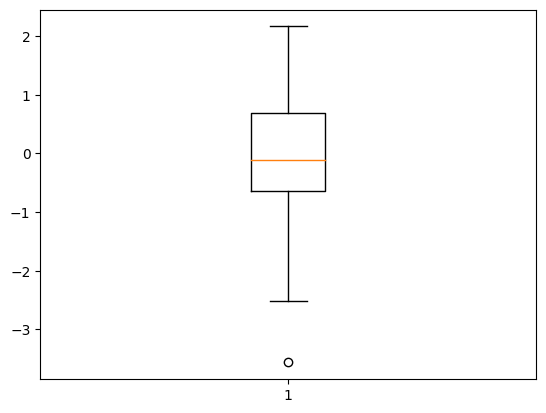

<Figure size 1000x700 with 0 Axes>

--------------------------------------------------
Statistics of owner_male
--------------------------------------------------
Min: 0
Max: 1
Mean: 0.5060975609756098
Median: 1.0
Standard deviation: 0.5007267039443399
Skewness: -0.024504262612026945
Variance: 0.2507272320429626
Kurtosis: -2.0117035495555706
Interquartile Range: 1.0 | Q1: 0.0 | Q3: 1.0


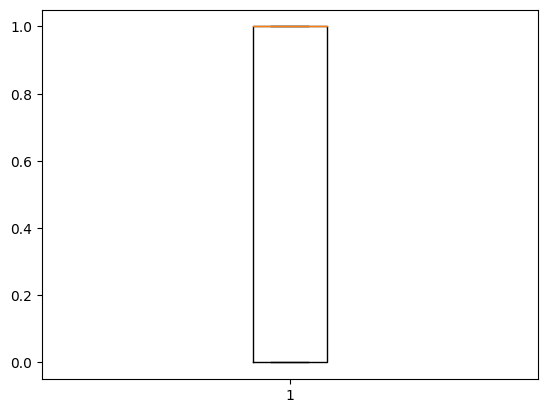

<Figure size 1000x700 with 0 Axes>

--------------------------------------------------
Statistics of owner_age
--------------------------------------------------
Min: -1.818422401901577
Max: 1.9373117550805647
Mean: -1.2185374660520012e-16
Median: -0.060419179484404
Standard deviation: 1.0015278847718296
Skewness: 0.09592305526228671
Variance: 1.003058103975535
Kurtosis: -1.0987081322214314
Interquartile Range: 1.6780939850345742 | Q1: -0.8595115533103918 | Q3: 0.8185824317241824


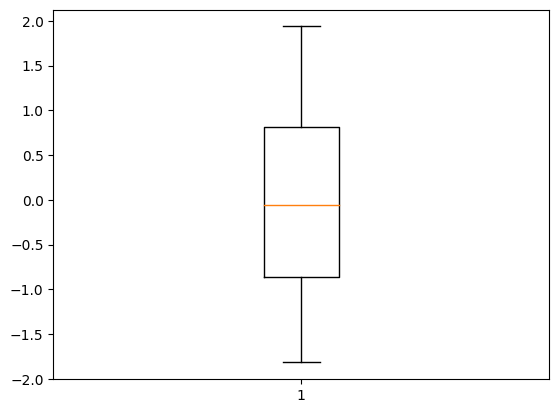

<Figure size 1000x700 with 0 Axes>

--------------------------------------------------
Statistics of account_age_months
--------------------------------------------------
Min: -1.637968444584631
Max: 1.8990444960430268
Mean: -3.5202193463724476e-17
Median: 0.0374587378179437
Standard deviation: 1.0015278847718296
Skewness: 0.2031662813019711
Variance: 1.003058103975535
Kurtosis: -1.0278988989319167
Interquartile Range: 1.6754271824025748 | Q1: -0.8933341412945978 | Q3: 0.782093041107977


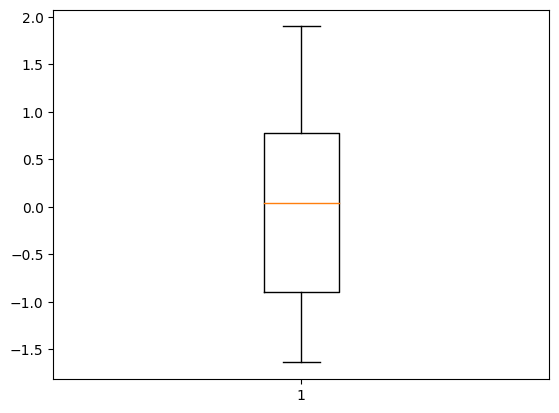

<Figure size 1000x700 with 0 Axes>

--------------------------------------------------
Statistics of has_disponent
--------------------------------------------------
Min: 0
Max: 1
Mean: 0.22865853658536586
Median: 0.0
Standard deviation: 0.420610484512994
Skewness: 1.2981423194213844
Variance: 0.17691317968225556
Kurtosis: -0.31679552925069077
Interquartile Range: 0.0 | Q1: 0.0 | Q3: 0.0


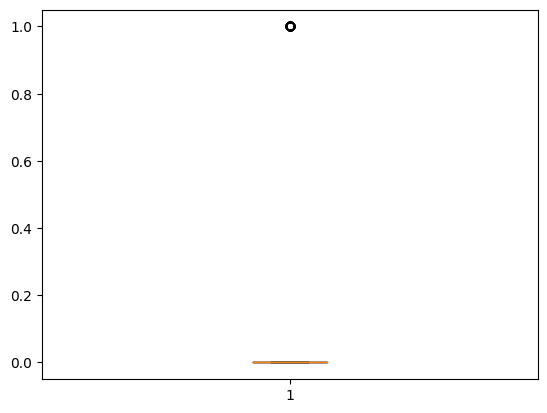

<Figure size 1000x700 with 0 Axes>

--------------------------------------------------
Statistics of owner_profile
--------------------------------------------------
Min: 0
Max: 2
Mean: 1.6341463414634145
Median: 2.0
Standard deviation: 0.7543909404658242
Skewness: -1.6460809402436805
Variance: 0.5691056910569107
Kurtosis: 0.8050571865237246
Interquartile Range: 0.0 | Q1: 2.0 | Q3: 2.0


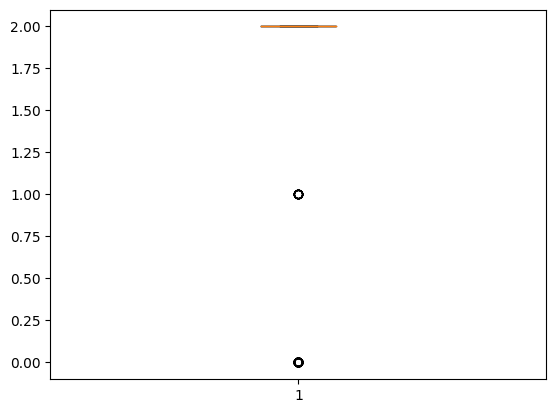

<Figure size 1000x700 with 0 Axes>

In [21]:
for col in data.columns:
    print("-"*50)
    print(f"Statistics of {col}")
    print("-"*50)
    #data[col].plot.box();

    q3, q1 = np.percentile(data[col], [75 ,25])

    print("Min: ", end="");                 print(data[col].min())
    print("Max: ", end="");                 print(data[col].max())
    print("Mean: ", end="");                print(data[col].mean())
    print("Median: ", end="");              print(data[col].median())
    print("Standard deviation: ", end="");  print(data[col].std())
    print("Skewness: ", end="");            print(data[col].skew())  
    print("Variance: ", end="");            print(data[col].var())
    print("Kurtosis: ", end="");            print(data[col].kurtosis())
    print("Interquartile Range: ", end=""); print(q3 - q1, end=" | "); print("Q1: {} | Q3: {}".format(q1,q3))
    plt.boxplot(data[col])
    fig = plt.figure(figsize =(10, 7))
    plt.show()

# var() method returns the unbiased variance
# Medium-High std which indicates that the data is spread out and not clustered around the mean
# Skewness > 1 => it is skewed to the right



## Standard Deviation

In [5]:
outliers_std = {}
for col in data.columns:
    data_mean, data_std = data[col].mean(), data[col].std()
    # identify outliers
    cut_off = data_std * 4
    lower, upper = data_mean - cut_off, data_mean + cut_off 
    outliers_std[col] = pd.concat([data.loc[data[col] < lower] , (data.loc[data[col] > upper])])

for key in outliers_std.keys():
    if (len(outliers_std[key]) > 0):
        print("-"*50)
        print(f"Outliers of {key} - mean: {data[key].mean()} - std: {data[key].std()}")
        print("-"*50)
        print(outliers_std[key][key])

--------------------------------------------------
Outliers of owner_card_type - mean: 0.0701219512195122 - std: 0.3886272992765306
--------------------------------------------------
33     2
88     2
201    2
244    2
252    2
263    2
271    2
276    2
321    3
322    3
Name: owner_card_type, dtype: int64
--------------------------------------------------
Outliers of count_trans_withdrawal_card - mean: 0.0701219512195122 - std: 0.5888546783181915
--------------------------------------------------
33     5
252    8
321    4
Name: count_trans_withdrawal_card, dtype: int64
--------------------------------------------------
Outliers of count_trans_ksymbol_sanction_interest_if_negative_balance - mean: 0.042682926829268296 - std: 0.20245012240637317
--------------------------------------------------
55     1
62     1
95     1
111    1
123    1
135    1
140    1
144    1
158    1
217    1
223    1
232    1
251    1
277    1
Name: count_trans_ksymbol_sanction_interest_if_negative_balance, dt

In [6]:
outliers_ids_std = set([val for key in outliers_std.keys() for val in outliers_std[key]['Id']])
outlier_ratio = len(outliers_ids_std) / len(data)
outlier_ratio

0.07317073170731707

## Z-Score

--------------------------------------------------
Outliers of owner_card_type - mean: 0.0701219512195122 - std: 0.3886272992765306
--------------------------------------------------
33     2
88     2
201    2
244    2
252    2
263    2
271    2
276    2
321    3
322    3
Name: owner_card_type, dtype: int64


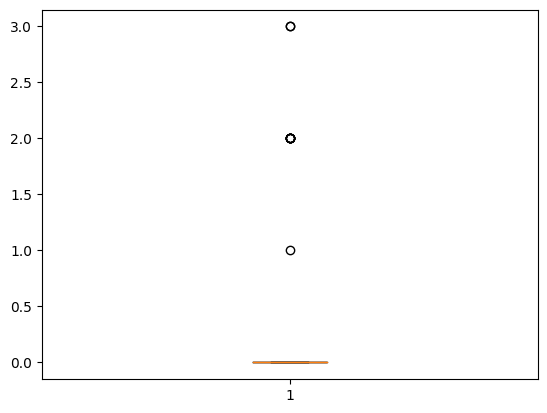

<Figure size 1000x700 with 0 Axes>

--------------------------------------------------
Outliers of count_trans_withdrawal_card - mean: 0.0701219512195122 - std: 0.5888546783181915
--------------------------------------------------
33     5
252    8
321    4
Name: count_trans_withdrawal_card, dtype: int64


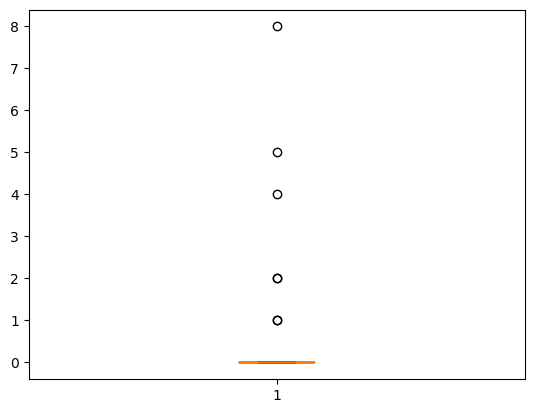

<Figure size 1000x700 with 0 Axes>

--------------------------------------------------
Outliers of count_trans_ksymbol_sanction_interest_if_negative_balance - mean: 0.042682926829268296 - std: 0.20245012240637317
--------------------------------------------------
55     1
62     1
95     1
111    1
123    1
135    1
140    1
144    1
158    1
217    1
223    1
232    1
251    1
277    1
Name: count_trans_ksymbol_sanction_interest_if_negative_balance, dtype: int64


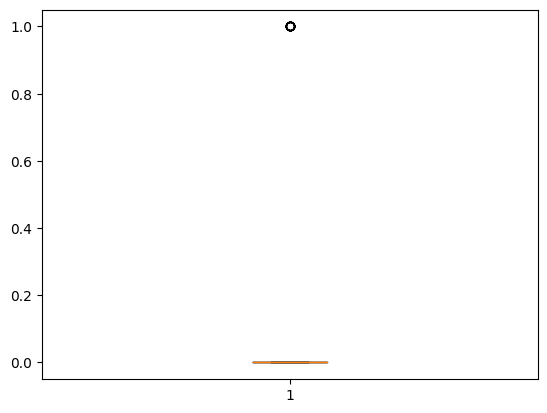

<Figure size 1000x700 with 0 Axes>

In [18]:
outliers_z = {}
for col in data.columns:
    z_val = (data[col] - data[col].mean()) / data[col].std()
    outliers_z[col] = data.loc[(z_val < -4) | (z_val > 4)]

for key in outliers_z.keys():
    if (len(outliers_z[key]) > 0):
        print("-"*50)
        print(f"Outliers of {key} - mean: {data[key].mean()} - std: {data[key].std()}")
        print("-"*50)
        print(f"{outliers_z[key][key]}")
        plt.boxplot(data[key])
        fig = plt.figure(figsize =(10, 7))
        plt.show()


In [11]:
outliers_ids_z = set([val for key in outliers_z.keys() for val in outliers_z[key]['Id']])
outlier_ratio = len(outliers_ids_z) / len(data)
outlier_ratio

0.07317073170731707

# Dataset without Outliers

In [9]:
outliers_ids = outliers_ids_std.union(outliers_ids_z)
manual_outlier_df = data.loc[~data['Id'].isin(outliers_ids)]
manual_outlier_df

,Id,loan_date,loan_duration,loan_payments,Predicted,account_frequency,account_district_region,account_district_no_inhabitants,account_district_no_municipalities_0_499,account_district_no_municipalities_500_1999,...,mean_trans_balance,mean_trans_amount_absolute,mean_trans_amount_credit,mean_trans_amount_withdrawal,mean_trans_amount_signed,owner_male,owner_age,account_age_months,has_disponent,owner_profile
0,5314,930705,12,1.772411,1.0,1,7,-0.555052,-0.696637,-0.532164,...,-2.341062,-1.095832,-1.277012,-3.548971,2.064417,0,0.738673,-1.637968,0,2
1,5316,930711,36,0.209593,0.0,2,3,-0.276803,0.251722,-0.103896,...,0.662960,0.445111,0.304714,0.259442,0.870102,1,-0.939421,-1.451810,0,2
2,6863,930728,60,-0.928164,0.0,2,3,-0.907746,1.315032,-0.165077,...,-0.997871,-0.973106,-1.279854,-0.405514,0.362060,1,1.697584,-1.265651,0,2
3,5325,930803,36,-0.553325,0.0,2,2,-0.344741,1.286294,0.446734,...,-0.150482,-0.193451,-0.489775,-0.135044,0.842490,0,1.377947,-1.079493,0,2
4,7240,930906,60,0.195440,0.0,1,4,1.729778,-1.127709,-1.327519,...,1.047898,1.926310,1.743982,1.716445,0.944229,1,-1.738513,-1.079493,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
323,6818,961212,48,-0.414986,0.0,2,1,0.598928,-0.208089,1.731539,...,0.068220,-1.137214,-1.012047,-1.070137,-0.537260,0,-0.859512,1.899044,1,2
324,5625,961215,60,-0.204510,1.0,2,7,-2.110760,0.366674,-0.715708,...,0.900256,0.595847,0.285059,0.536220,0.540540,1,1.697584,0.037459,0,2
325,6805,961221,48,-1.466909,0.0,2,1,0.822776,-1.127709,-1.205157,...,-0.097886,-0.313022,-0.621863,-0.182382,0.514984,0,0.259218,-0.893334,0,2
326,7233,961225,36,-0.426400,0.0,2,6,-0.570905,0.998913,-0.042715,...,1.007047,0.910852,0.869015,0.695252,-0.583636,1,0.578855,1.340569,0,2


--------------------------------------------------
Outliers of owner_card_type - mean: 0.0701219512195122 - std: 0.3886272992765306
--------------------------------------------------
33     2
88     2
201    2
244    2
252    2
263    2
271    2
276    2
321    3
322    3
Name: owner_card_type, dtype: int64


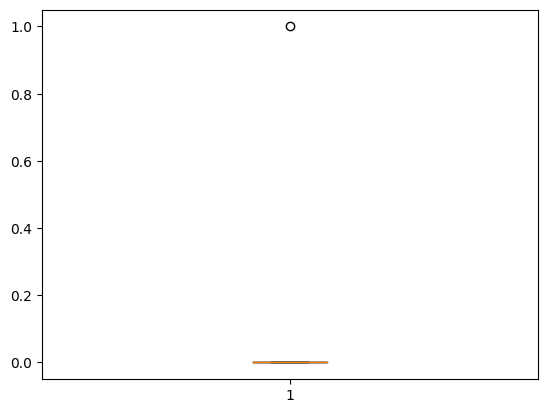

<Figure size 1000x700 with 0 Axes>

--------------------------------------------------
Outliers of count_trans_withdrawal_card - mean: 0.0701219512195122 - std: 0.5888546783181915
--------------------------------------------------
33     5
252    8
321    4
Name: count_trans_withdrawal_card, dtype: int64


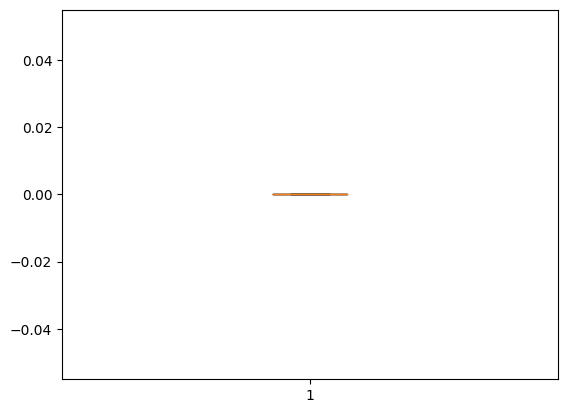

<Figure size 1000x700 with 0 Axes>

--------------------------------------------------
Outliers of count_trans_ksymbol_sanction_interest_if_negative_balance - mean: 0.042682926829268296 - std: 0.20245012240637317
--------------------------------------------------
55     1
62     1
95     1
111    1
123    1
135    1
140    1
144    1
158    1
217    1
223    1
232    1
251    1
277    1
Name: count_trans_ksymbol_sanction_interest_if_negative_balance, dtype: int64


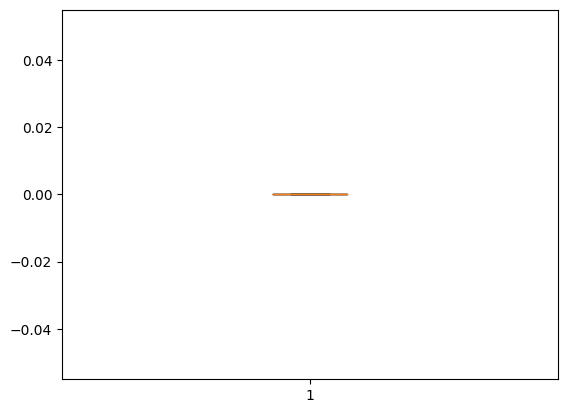

<Figure size 1000x700 with 0 Axes>

In [20]:
for key in outliers_z.keys():
    if (len(outliers_z[key]) > 0):
        print("-"*50)
        print(f"Outliers of {key} - mean: {data[key].mean()} - std: {data[key].std()}")
        print("-"*50)
        print(f"{outliers_z[key][key]}")
        plt.boxplot(manual_outlier_df[key])
        fig = plt.figure(figsize =(10, 7))
        plt.show()

In [10]:
manual_outlier_df.to_csv('output/loan_dev_transformed_outliers.csv', index=False)